# Introduction

Large deep learning models can take a long time to train.  To accelerate training, you can use "hardware accelerators" like GPUs (Graphics Processing Units) and [TPUs](https://www.kaggle.com/docs/tpu) (Tensor Processing Units). 

<center>
<img src="https://i.imgur.com/ZLJBzWp.png" width=30%><br/>
</center>

On Kaggle, you can train deep learning models with GPUs and TPUs for free!
- You can use 30 hours per week (sometimes more) of GPUs and up to 9 hours at a time in a single session.
- You can use 30 hours per week of TPUs and up to 3 hours at a time in a single session.

In this tutorial, you'll use a TPU to train a deep learning model and submit the results to the [Petals to the Metal](https://www.kaggle.com/c/tpu-getting-started) competition.  

We won't dive into the details, and you should not understand all of the code that you see here.  At the end of this tutorial, we recommend additional resources that you can use to learn more.


# Step 1: Connect to the TPU

We begin by importing several Python packages and connecting to the TPU.

In [1]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.2.0
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


If you see `Running on TPU` in the output above, that means that your Kaggle notebook has successfully connected to the TPU.

# Step 2: Access and configure the data

The next code cell will let the TPU access the competition data.  (Before running this cell, you have to attach the [competition dataset](https://www.kaggle.com/c/tpu-getting-started) to the notebook, and we have already done this for you.)

It also defines several settings that we'll need to use when working with the data (like the image size and filenames).

In [2]:
IMAGE_SIZE = [512, 512]                   
EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_DS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('{} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

12753 training images, 3712 validation images, 7382 unlabeled test images


# Step 3: Define a model

We define a model architecture.

In [3]:
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


# Step 4: Train the model

There are several helper functions that we'll need to use to train a model.  These are defined in the hidden code cell below.

In [4]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

The next code cell trains the model.

In [5]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=get_validation_dataset())

Epoch 1/12
99/99 [==============================] - 27s 273ms/step - sparse_categorical_accuracy: 0.0819 - loss: 4.1202 - val_sparse_categorical_accuracy: 0.1519 - val_loss: 3.8854
Epoch 2/12
99/99 [==============================] - 17s 173ms/step - sparse_categorical_accuracy: 0.1747 - loss: 3.7599 - val_sparse_categorical_accuracy: 0.1937 - val_loss: 3.6408
Epoch 3/12
99/99 [==============================] - 17s 171ms/step - sparse_categorical_accuracy: 0.2108 - loss: 3.5393 - val_sparse_categorical_accuracy: 0.2260 - val_loss: 3.4522
Epoch 4/12
99/99 [==============================] - 16s 166ms/step - sparse_categorical_accuracy: 0.2424 - loss: 3.3606 - val_sparse_categorical_accuracy: 0.2535 - val_loss: 3.2996
Epoch 5/12
99/99 [==============================] - 16s 166ms/step - sparse_categorical_accuracy: 0.2682 - loss: 3.2207 - val_sparse_categorical_accuracy: 0.2742 - val_loss: 3.1646
Epoch 6/12
99/99 [==============================] - 16s 166ms/step - sparse_categorical_accurac

We can see that accuracy (`sparse_categorical_accuracy`) increases with training epoch, while the loss decreases over time: which is what we want!

# Step 5: Visualization

Next, we'll visualize how the model performs with some images from the validation set.

We begin by defining a (hidden) code cell with some helper functions.

In [6]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

Pictures with red titles show examples where the model made a mistake.  Titles in black show correct classifications.

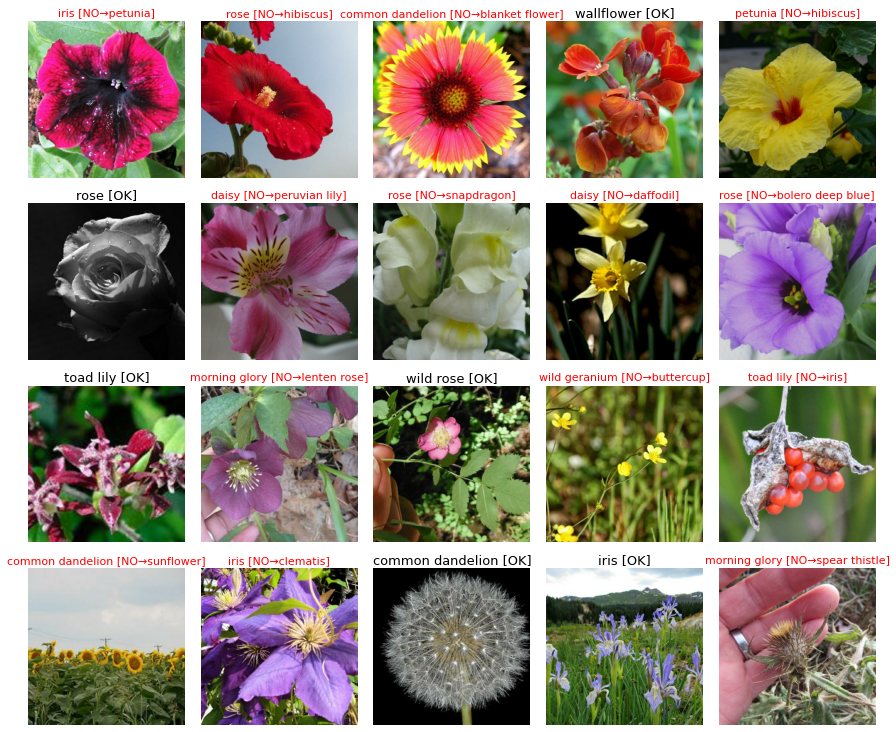

In [7]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 6: Make a submission

If you have not yet already, begin by clicking on the **[Copy and Edit]** button in the top right corner of this notebook.  Then, submit to the competition by following these steps:
#$SUBMIT_TO_COMP$

In [8]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28 103 ...  48  53  53]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,103
00e4f514e,103
59d1b6146,53
8d808a07b,53
aeb67eefb,103
53cfc6586,48
aaa580243,67


# Learn more

In this tutorial, you saw how to leverage TPUs to quickly make a submission to a Kaggle competition.  

If you took Kaggle Learn's [**Deep Learning course**](https://www.kaggle.com/learn/deep-learning), then some of the code should look familiar; for instance, you define a neural network architecture with `tf.keras.Sequential()`, before compiling and training the model with `model.compile()` and `model.fit()`.

If you're interested in learning about the details of the code presented here, we'll soon release a new **Computer Vision course** that will help you understand the code in **Step 3** of this notebook, by teaching you about topics like convolutional neural networks and transfer learning.  Until then, you're encouraged to check out the [Petals to the Metal discussion forums](https://www.kaggle.com/c/tpu-getting-started/discussion) to continue your leanring!